# Système de Reconnaissance de Chiffres Multiples

Ce notebook implémente un système complet pour :\
    - Entraîner un modèle sur des chiffres individuels\
    - Segmenter une image contenant plusieurs chiffres\
    - Prédire chaque chiffre individuellement\
    - Visualiser les résultats

## 1. Installation et Importation des Bibliothèques

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import joblib
import warnings
warnings.filterwarnings('ignore')

## 2. Classe Principale du Système

In [2]:
class DigitRecognitionSystem:
    def __init__(self, image_size=(28, 28)):
        self.image_size = image_size
        self.model = None
        self.scaler = StandardScaler()
        
    def load_dataset_from_folder(self, root_dir):
        """
        Charge le dataset depuis un dossier organisé par labels
        """
        X = []
        Y = []
        
        print("📁 Chargement du dataset...")
        for label in sorted(os.listdir(root_dir)):
            label_path = os.path.join(root_dir, label)
            if not os.path.isdir(label_path):
                continue
                
            image_count = 0
            for fname in os.listdir(label_path):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(label_path, fname)
                    try:
                        img = Image.open(img_path).convert("L").resize(self.image_size)
                        X.append(np.array(img).flatten())
                        Y.append(int(label))
                        image_count += 1
                    except Exception as e:
                        print(f"❌ Erreur lors du chargement de {img_path}: {e}")
                        
            print(f"   Label {label}: {image_count} images chargées")
            
        return np.array(X), np.array(Y)
    
    def preprocess_image_for_segmentation(self, image_path):
        """
        Prétraite une image pour la segmentation des chiffres
        """
        # Charger l'image
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Impossible de charger l'image: {image_path}")
            
        # Appliquer un flou gaussien pour réduire le bruit
        img = cv2.GaussianBlur(img, (5, 5), 0)
        
        # Binarisation adaptative
        binary = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                     cv2.THRESH_BINARY_INV, 11, 2)
        
        return binary
    
    def segment_digits(self, binary_image):
        """
        Segmente les chiffres individuels d'une image binaire
        """
        # Trouver les contours
        contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Filtrer et trier les contours
        digit_contours = []
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            
            # Filtrer par taille (ajustez selon vos besoins)
            if w > 10 and h > 10 and w < 200 and h < 200:
                # Ratio largeur/hauteur raisonnable pour un chiffre
                aspect_ratio = w / h
                if 0.2 <= aspect_ratio <= 2.0:
                    digit_contours.append((x, y, w, h))
        
        # Trier de gauche à droite
        digit_contours.sort(key=lambda x: x[0])
        
        # Extraire les régions de chiffres
        digit_images = []
        for x, y, w, h in digit_contours:
            # Ajouter un peu de padding
            padding = 5
            x_start = max(0, x - padding)
            y_start = max(0, y - padding)
            x_end = min(binary_image.shape[1], x + w + padding)
            y_end = min(binary_image.shape[0], y + h + padding)
            
            digit_roi = binary_image[y_start:y_end, x_start:x_end]
            
            # Redimensionner à la taille du modèle
            digit_resized = cv2.resize(digit_roi, self.image_size)
            
            # Normaliser (inverser si nécessaire pour avoir fond noir, chiffre blanc)
            if np.mean(digit_resized) > 127:
                digit_resized = 255 - digit_resized
                
            digit_images.append(digit_resized)
        
        return digit_images, digit_contours
    
    def train_model(self, X_train, y_train, model_type='knn'):
        """
        Entraîne le modèle de classification
        """
        print(f"🚀 Entraînement du modèle {model_type.upper()}...")
        
        # Normalisation des données
        X_train_scaled = self.scaler.fit_transform(X_train)
        
        # Choix du modèle
        if model_type == 'knn':
            self.model = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
        elif model_type == 'svm':
            self.model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
        elif model_type == 'rf':
            self.model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        else:
            raise ValueError("Type de modèle non supporté")
            
        self.model.fit(X_train_scaled, y_train)
        print(f"✅ Modèle {model_type.upper()} entraîné avec succès!")
        
    def evaluate_model(self, X_test, y_test):
        """
        Évalue le modèle sur les données de test
        """
        if self.model is None:
            raise ValueError("Le modèle n'est pas encore entraîné")
            
        X_test_scaled = self.scaler.transform(X_test)
        y_pred = self.model.predict(X_test_scaled)
        
        print("\n📊 Rapport de classification:")
        print(classification_report(y_test, y_pred))
        
        return y_pred
    
    def predict_single_digit(self, digit_image):
        """
        Prédit un chiffre unique
        """
        if self.model is None:
            raise ValueError("Le modèle n'est pas encore entraîné")
            
        # Aplatir et normaliser l'image
        digit_flat = digit_image.flatten().reshape(1, -1)
        digit_scaled = self.scaler.transform(digit_flat)
        
        # Prédiction
        prediction = self.model.predict(digit_scaled)[0]
        
        # Confidence (probabilité)
        if hasattr(self.model, 'predict_proba'):
            confidence = self.model.predict_proba(digit_scaled)[0].max()
        else:
            # Pour les modèles sans predict_proba, utiliser une mesure alternative
            confidence = 1.0  # Placeholder
        
        return prediction, confidence
    
    def process_multi_digit_image(self, image_path, visualize=True):
        """
        Traite une image contenant plusieurs chiffres
        """
        print(f"🔍 Traitement de l'image ...")
        
        # Prétraitement
        binary_image = self.preprocess_image_for_segmentation(image_path)
        
        # Segmentation
        digit_images, digit_contours = self.segment_digits(binary_image)
        
        if len(digit_images) == 0:
            print("⚠️ Aucun chiffre détecté dans l'image")
            return [], []
        
        # Prédictions
        predictions = []
        confidences = []
        
        for digit_img in digit_images:
            pred, conf = self.predict_single_digit(digit_img)
            predictions.append(pred)
            confidences.append(conf)
        
        # Visualisation
        if visualize:
            self.visualize_results(image_path, binary_image, digit_images, 
                                 predictions, confidences, digit_contours)
        
        return predictions, confidences
    
    def visualize_results(self, original_path, binary_image, digit_images, 
                         predictions, confidences, digit_contours):
        """
        Visualise les résultats de la reconnaissance
        """
        # Image originale
        original = cv2.imread(original_path, cv2.IMREAD_GRAYSCALE)
        
        # Configuration de l'affichage
        n_digits = len(digit_images)
        n_cols = max(3, n_digits + 1)
        
        fig, axes = plt.subplots(3, n_cols, figsize=(15, 10))
        
        # Ligne 1: Image originale avec boîtes englobantes
        axes[0, 0].imshow(original, cmap='gray')
        axes[0, 0].set_title('🖼️ Image Originale', fontsize=12, fontweight='bold')
        axes[0, 0].axis('off')
        
        # Dessiner les boîtes englobantes
        for i, (x, y, w, h) in enumerate(digit_contours):
            rect = plt.Rectangle((x, y), w, h, fill=False, 
                               edgecolor='red', linewidth=2)
            axes[0, 0].add_patch(rect)
            axes[0, 0].text(x, y-5, f'{predictions[i]}', 
                           color='red', fontsize=14, fontweight='bold',
                           bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8))
        
        # Ligne 2: Image binaire
        axes[1, 0].imshow(binary_image, cmap='gray')
        axes[1, 0].set_title('🔲 Image Binaire', fontsize=12, fontweight='bold')
        axes[1, 0].axis('off')
        
        # Ligne 3: Résultats globaux
        result_text = f"📋 Résultats:\n"
        result_text += f"Chiffres détectés: {len(predictions)}\n"
        result_text += f"Séquence: {''.join(map(str, predictions))}\n"
        result_text += f"Confiance moy: {np.mean(confidences):.3f}"
        
        axes[2, 0].text(0.5, 0.5, result_text, 
                       transform=axes[2, 0].transAxes, ha='center', va='center',
                       fontsize=11, bbox=dict(boxstyle="round,pad=0.5", 
                                            facecolor="lightgreen", alpha=0.7))
        axes[2, 0].axis('off')
        
        # Colonnes suivantes: Chiffres segmentés
        for i, (digit_img, pred, conf) in enumerate(zip(digit_images, predictions, confidences)):
            col = i + 1
            if col < n_cols:
                # Ligne 1: Chiffre segmenté
                axes[0, col].imshow(digit_img, cmap='gray')
                axes[0, col].set_title(f'Chiffre {i+1}', fontsize=10)
                axes[0, col].axis('off')
                
                # Ligne 2: Chiffre redimensionné (même vue mais avec cadre)
                axes[1, col].imshow(digit_img, cmap='gray')
                axes[1, col].set_title(f'28x28px', fontsize=10)
                axes[1, col].axis('off')
                
                # Ligne 3: Prédiction et confiance
                pred_text = f'🔢 Prédiction: {pred}\n📊 Confiance: {conf:.3f}'
                color = 'lightblue' if conf > 0.8 else 'lightyellow' if conf > 0.6 else 'lightcoral'
                
                axes[2, col].text(0.5, 0.5, pred_text, 
                                 transform=axes[2, col].transAxes, ha='center', va='center',
                                 fontsize=10, bbox=dict(boxstyle="round,pad=0.3", 
                                                       facecolor=color, alpha=0.7))
                axes[2, col].axis('off')
        
        # Masquer les axes non utilisés
        for i in range(len(digit_images) + 1, n_cols):
            for j in range(3):
                axes[j, i].axis('off')
        
        plt.tight_layout()
        plt.suptitle('🎯 Résultats de la Reconnaissance de Chiffres Multiples', 
                     fontsize=16, fontweight='bold', y=0.98)
        plt.show()
        
        # Résumé textuel
        print(f"\n📈 RÉSUMÉ DES RÉSULTATS:")
        print(f"   Nombre de chiffres détectés: {len(predictions)}")
        print(f"   Séquence prédite: {''.join(map(str, predictions))}")
        print(f"   Confiance moyenne: {np.mean(confidences):.3f}")
        print("\n🔍 DÉTAILS PAR CHIFFRE:")
        for i, (pred, conf) in enumerate(zip(predictions, confidences)):
            status = "🟢" if conf > 0.8 else "🟡" if conf > 0.6 else "🔴"
            print(f"   {status} Chiffre {i+1}: {pred} (confiance: {conf:.3f})")
    
    def save_model(self, model_path):
        """
        Sauvegarde le modèle et le scaler
        """
        if self.model is None:
            raise ValueError("Aucun modèle à sauvegarder")
            
        joblib.dump({
            'model': self.model,
            'scaler': self.scaler,
            'image_size': self.image_size
        }, model_path)
        print(f"💾 Modèle sauvegardé: {model_path}")
    
    def load_model(self, model_path):
        """
        Charge un modèle pré-entraîné
        """
        data = joblib.load(model_path)
        self.model = data['model']
        self.scaler = data['scaler']
        self.image_size = data['image_size']
        print(f"📂 Modèle chargé: {model_path}")


## 3. Configuration et Chargement des Données

In [ ]:
digit_system = DigitRecognitionSystem(image_size=(28, 28))

DATASET_PATH = "../../data/digits-hand-sampled"
MODEL_SAVE_PATH = "models/digit_recognition_model.pkl"
# Vérifier si le dataset existe
if os.path.exists(DATASET_PATH):
    print("✅ Dataset trouvé")
else:
    print(f"❌ Dataset non trouvé: {DATASET_PATH}")
    print("📋 Veuillez ajuster la variable DATASET_PATH avec le bon chemin vers votre dataset")


✅ Dataset trouvé


## 4. Chargement et Préparation des Données

📁 Chargement du dataset...
   Label 0: 6903 images chargées
   Label 1: 7877 images chargées
   Label 2: 6990 images chargées
   Label 3: 7141 images chargées
   Label 4: 6824 images chargées
   Label 5: 6313 images chargées
   Label 6: 6876 images chargées
   Label 7: 7293 images chargées
   Label 8: 6825 images chargées
   Label 9: 6958 images chargées

📊 STATISTIQUES DU DATASET:
   Nombre total d'images: 70000
   Dimensions des images: 784 pixels (28x28)
   Nombre de classes: 10
   Classes détectées: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]


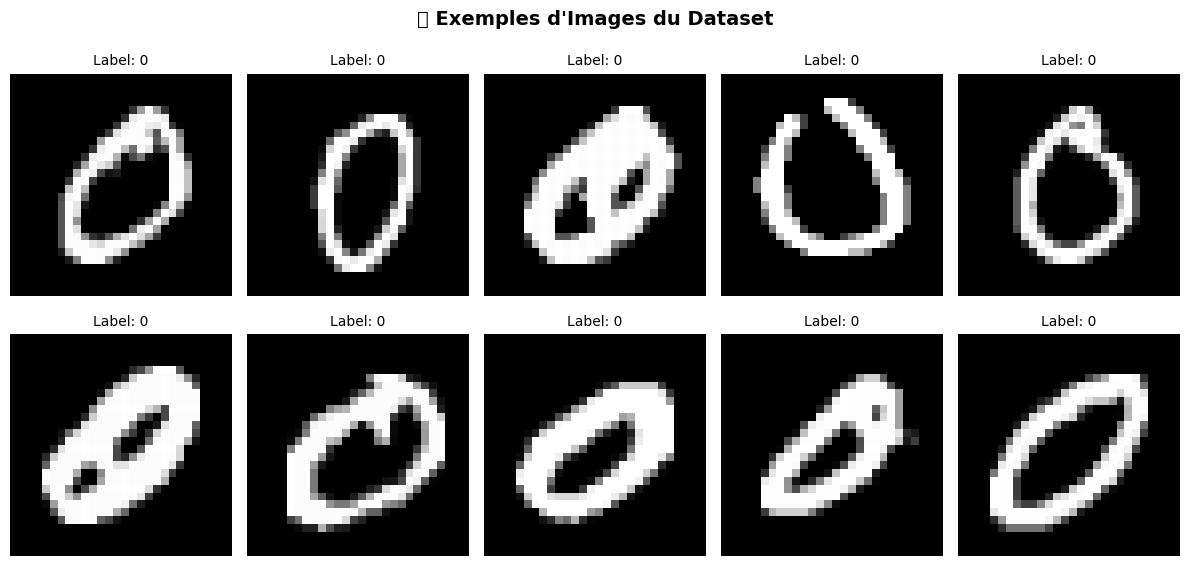

In [4]:
# Charger le dataset
try:
    X, y = digit_system.load_dataset_from_folder(DATASET_PATH)
    
    print(f"\n📊 STATISTIQUES DU DATASET:")
    print(f"   Nombre total d'images: {X.shape[0]}")
    print(f"   Dimensions des images: {X.shape[1]} pixels ({int(np.sqrt(X.shape[1]))}x{int(np.sqrt(X.shape[1]))})")
    print(f"   Nombre de classes: {len(np.unique(y))}")
    print(f"   Classes détectées: {sorted(np.unique(y))}")
    
    # Afficher quelques exemples
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    for i, ax in enumerate(axes.ravel()):
        if i < len(X):
            ax.imshow(X[i].reshape(28, 28), cmap="gray")
            ax.set_title(f'Label: {y[i]}', fontsize=10)
            ax.axis("off")
    
    plt.suptitle('🖼️ Exemples d\'Images du Dataset', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    dataset_loaded = True
    
except Exception as e:
    print(f"❌ Erreur lors du chargement: {e}")
    dataset_loaded = False


## 5. Division des Données et Entraînement

In [5]:
if dataset_loaded:
    # Division train/test
    print("📊 Division des données...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"   Données d'entraînement: {X_train.shape[0]} images")
    print(f"   Données de test: {X_test.shape[0]} images")
    
    # Distribution des classes
    unique, counts = np.unique(y_train, return_counts=True)
    print(f"\n📈 Distribution des classes (entraînement):")
    for label, count in zip(unique, counts):
        print(f"   Classe {label}: {count} images")
else:
    print("⚠️ Impossible de continuer sans dataset")


if dataset_loaded:
    # Choix du modèle
    MODEL_TYPE = 'knn'  # 🔧 Changez en 'svm' ou 'rf' si nécessaire
    
    print(f"🚀 ENTRAÎNEMENT DU MODÈLE {MODEL_TYPE.upper()}")
    print("   (Cela peut prendre quelques minutes...)")
    
    # Entraîner le modèle
    digit_system.train_model(X_train, y_train, model_type=MODEL_TYPE)
    
    model_trained = True
else:
    model_trained = False

📊 Division des données...
   Données d'entraînement: 56000 images
   Données de test: 14000 images

📈 Distribution des classes (entraînement):
   Classe 0: 5522 images
   Classe 1: 6302 images
   Classe 2: 5592 images
   Classe 3: 5713 images
   Classe 4: 5459 images
   Classe 5: 5050 images
   Classe 6: 5501 images
   Classe 7: 5834 images
   Classe 8: 5460 images
   Classe 9: 5567 images
🚀 ENTRAÎNEMENT DU MODÈLE KNN
   (Cela peut prendre quelques minutes...)
🚀 Entraînement du modèle KNN...
✅ Modèle KNN entraîné avec succès!


## 6. Évaluation du Modèle

🎯 ÉVALUATION DU MODÈLE

📊 Rapport de classification:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1381
           1       0.95      0.99      0.97      1575
           2       0.95      0.94      0.95      1398
           3       0.92      0.95      0.94      1428
           4       0.95      0.93      0.94      1365
           5       0.94      0.92      0.93      1263
           6       0.96      0.97      0.97      1375
           7       0.94      0.95      0.94      1459
           8       0.97      0.89      0.93      1365
           9       0.92      0.92      0.92      1391

    accuracy                           0.95     14000
   macro avg       0.95      0.95      0.95     14000
weighted avg       0.95      0.95      0.95     14000



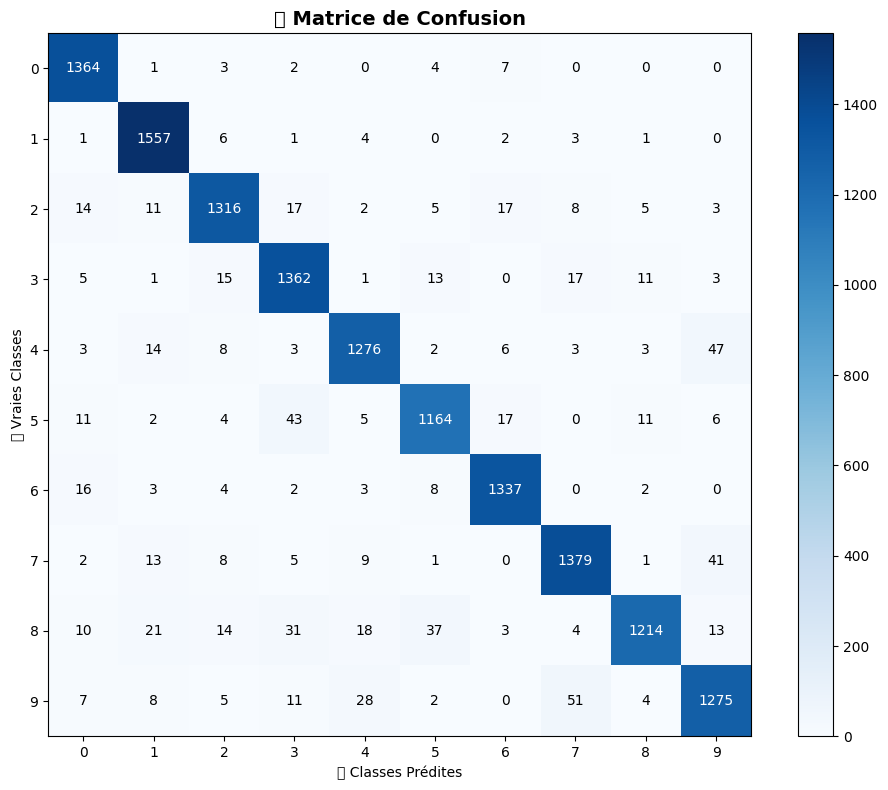

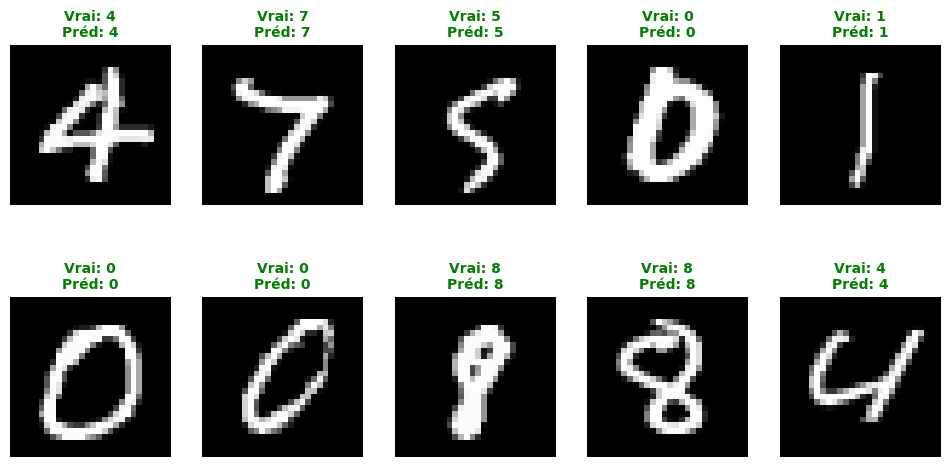

In [6]:
if model_trained:
    print("🎯 ÉVALUATION DU MODÈLE")
    y_pred = digit_system.evaluate_model(X_test, y_test)
    
    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    
    # Visualiser la matrice de confusion
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title('📊 Matrice de Confusion', fontsize=14, fontweight='bold')
    plt.colorbar()
    
    # Ajouter les labels
    classes = sorted(np.unique(y))
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    # Ajouter le texte dans chaque case
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('📋 Vraies Classes')
    plt.xlabel('🔮 Classes Prédites')
    plt.tight_layout()
    plt.show()
    
    # Exemples de prédictions
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    indices = np.random.choice(len(X_test), 10, replace=False)
    
    for i, (ax, idx) in enumerate(zip(axes.ravel(), indices)):
        ax.imshow(X_test[idx].reshape(28, 28), cmap="gray")
        true_label = y_test[idx]
        pred_label = y_pred[idx]
        
        # Couleur selon la correction de la prédiction
        color = 'green' if true_label == pred_label else 'red'
        ax.set_title(f'Vrai: {true_label}\nPréd: {pred_label}', 
                    color=color, fontsize=10, fontweight='bold')
        ax.axis("off")

## 7. Sauvegarde du Modèle

In [7]:

if model_trained:
    # Sauvegarder le modèle
    MODEL_SAVE_PATH= "../../models/digit_recognition_model.pkl"
    digit_system.save_model(MODEL_SAVE_PATH)
    print(f"✅ Modèle sauvegardé et prêt à être utilisé!")

💾 Modèle sauvegardé: ../../models/digit_recognition_model.pkl
✅ Modèle sauvegardé et prêt à être utilisé!


## 8. Test sur Images Multi-Chiffres

🔍 TEST SUR IMAGE MULTI-CHIFFRES
🔍 Traitement de l'image ...


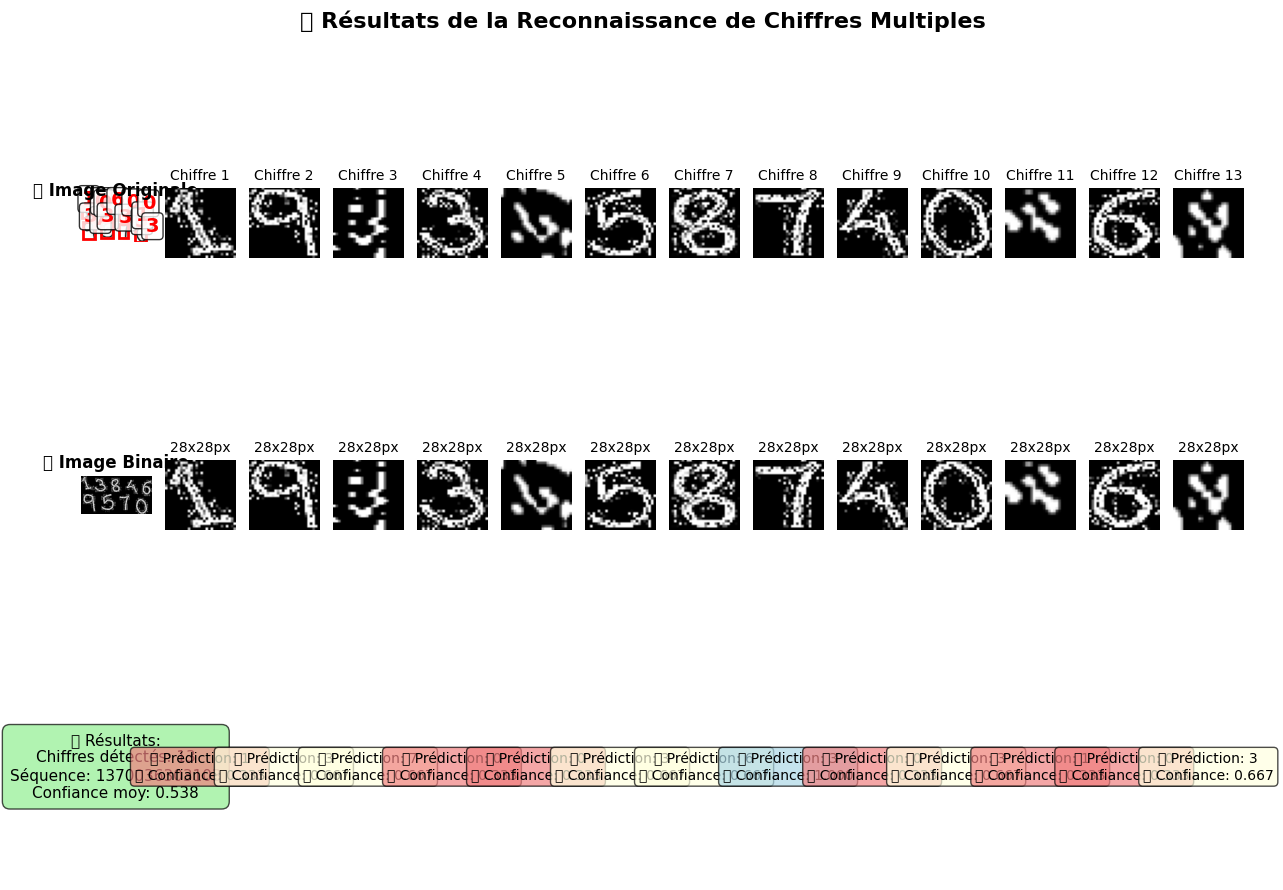


📈 RÉSUMÉ DES RÉSULTATS:
   Nombre de chiffres détectés: 13
   Séquence prédite: 1370036303103
   Confiance moyenne: 0.538

🔍 DÉTAILS PAR CHIFFRE:
   🔴 Chiffre 1: 1 (confiance: 0.333)
   🟡 Chiffre 2: 3 (confiance: 0.667)
   🟡 Chiffre 3: 7 (confiance: 0.667)
   🔴 Chiffre 4: 0 (confiance: 0.333)
   🔴 Chiffre 5: 0 (confiance: 0.333)
   🟡 Chiffre 6: 3 (confiance: 0.667)
   🟡 Chiffre 7: 6 (confiance: 0.667)
   🟢 Chiffre 8: 3 (confiance: 1.000)
   🔴 Chiffre 9: 0 (confiance: 0.333)
   🟡 Chiffre 10: 3 (confiance: 0.667)
   🔴 Chiffre 11: 1 (confiance: 0.333)
   🔴 Chiffre 12: 0 (confiance: 0.333)
   🟡 Chiffre 13: 3 (confiance: 0.667)

🎉 TEST TERMINÉ AVEC SUCCÈS!


In [13]:
# Créer ou utiliser une image de test
TEST_IMAGE_PATH = '../../data/sample_images/exemple2-digits-hands.png'  # 🔧 

if model_trained and os.path.exists(TEST_IMAGE_PATH):
    print("🔍 TEST SUR IMAGE MULTI-CHIFFRES")
    
    try:
        # Traiter l'image
        predictions, confidences = digit_system.process_multi_digit_image(
            TEST_IMAGE_PATH, visualize=True
        )
        
        print("\n🎉 TEST TERMINÉ AVEC SUCCÈS!")
        
    except Exception as e:
        print(f"❌ Erreur lors du traitement: {e}")
        print("💡 Vérifiez que l'image contient des chiffres bien visibles")


## 9. Préparation pour Images Manuscrites Réelles

In [14]:
def preprocess_handwritten_image(image_path, output_path=None):
    """
    Prétraitement spécialisé pour images manuscrites réelles
    """
    import cv2
    
    # Charger l'image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Impossible de charger l'image: {image_path}")
    
    # Convertir en niveaux de gris
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Améliorer le contraste
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)
    
    # Débruitage
    denoised = cv2.medianBlur(enhanced, 3)
    
    # Binarisation adaptative avec différents paramètres
    binary1 = cv2.adaptiveThreshold(denoised, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                   cv2.THRESH_BINARY_INV, 15, 10)
    
    # Alternative avec seuillage d'Otsu
    _, binary2 = cv2.threshold(denoised, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Morphologie pour nettoyer
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
    cleaned = cv2.morphologyEx(binary1, cv2.MORPH_CLOSE, kernel)
    
    # Sauvegarder si demandé
    if output_path:
        cv2.imwrite(output_path, cleaned)
        print(f"💾 Image prétraitée sauvegardée: {output_path}")
    
    # Visualiser les étapes
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 4, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('📸 Original')
    plt.axis('off')
    
    plt.subplot(2, 4, 2)
    plt.imshow(gray, cmap='gray')
    plt.title('⚫ Niveaux de gris')
    plt.axis('off')
    
    plt.subplot(2, 4, 3)
    plt.imshow(enhanced, cmap='gray')
    plt.title('✨ Contraste amélioré')
    plt.axis('off')
    
    plt.subplot(2, 4, 4)
    plt.imshow(denoised, cmap='gray')
    plt.title('🔇 Débruité')
    plt.axis('off')
    
    plt.subplot(2, 4, 5)
    plt.imshow(binary1, cmap='gray')
    plt.title('🔲 Binarisation adaptative')
    plt.axis('off')
    
    plt.subplot(2, 4, 6)
    plt.imshow(binary2, cmap='gray')
    plt.title('🎯 Seuillage d\'Otsu')
    plt.axis('off')
    
    plt.subplot(2, 4, 7)
    plt.imshow(cleaned, cmap='gray')
    plt.title('🧹 Nettoyé')
    plt.axis('off')
    
    plt.subplot(2, 4, 8)
    # Histogramme des intensités
    plt.hist(gray.ravel(), 256, [0,256])
    plt.title('📊 Histogramme')
    plt.xlabel('Intensité')
    plt.ylabel('Fréquence')
    
    plt.tight_layout()
    plt.suptitle('🔄 Étapes de Prétraitement pour Image Manuscrite', fontsize=16, y=1.02)
    plt.show()
    
    return cleaned

print("✅ Fonction de prétraitement pour images manuscrites créée!")


✅ Fonction de prétraitement pour images manuscrites créée!


## 10. Système de Segmentation Avancé pour Manuscrit

In [10]:
class HandwrittenDigitProcessor:
    def __init__(self, digit_system):
        self.digit_system = digit_system
    
    def detect_text_lines(self, binary_image):
        """
        Détecte les lignes de texte dans l'image
        """
        # Projection horizontale pour détecter les lignes
        horizontal_projection = np.sum(binary_image, axis=1)
        
        # Trouver les zones avec du texte
        line_threshold = np.max(horizontal_projection) * 0.1
        text_rows = np.where(horizontal_projection > line_threshold)[0]
        
        if len(text_rows) == 0:
            return [binary_image]
        
        # Grouper les lignes continues
        lines = []
        start_row = text_rows[0]
        
        for i in range(1, len(text_rows)):
            if text_rows[i] - text_rows[i-1] > 10:  # Gap entre lignes
                end_row = text_rows[i-1]
                lines.append((start_row, end_row))
                start_row = text_rows[i]
        
        lines.append((start_row, text_rows[-1]))
        
        # Extraire chaque ligne
        line_images = []
        for start, end in lines:
            # Ajouter un peu de padding
            start = max(0, start - 5)
            end = min(binary_image.shape[0], end + 5)
            line_img = binary_image[start:end, :]
            line_images.append(line_img)
        
        return line_images
    
    def segment_digits_advanced(self, binary_image, min_width=8, min_height=15):
        """
        Segmentation avancée pour chiffres manuscrits
        """
        # Détection des lignes
        line_images = self.detect_text_lines(binary_image)
        
        all_digits = []
        all_positions = []
        line_results = []
        
        for line_idx, line_img in enumerate(line_images):
            print(f"📝 Traitement de la ligne {line_idx + 1}")
            
            # Projection verticale pour cette ligne
            vertical_projection = np.sum(line_img, axis=0)
            
            # Trouver les contours dans cette ligne
            contours, _ = cv2.findContours(line_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            # Filtrer et trier les contours
            digit_candidates = []
            for contour in contours:
                x, y, w, h = cv2.boundingRect(contour)
                
                # Filtres pour les chiffres manuscrits
                if (w >= min_width and h >= min_height and 
                    w <= line_img.shape[1]//2 and h <= line_img.shape[0]):
                    
                    aspect_ratio = w / h
                    area = cv2.contourArea(contour)
                    
                    # Filtres supplémentaires
                    if 0.1 <= aspect_ratio <= 3.0 and area > 50:
                        digit_candidates.append((x, y, w, h, area))
            
            # Trier par position x (gauche à droite)
            digit_candidates.sort(key=lambda x: x[0])
            
            # Traiter les chevauchements
            filtered_candidates = []
            for i, (x, y, w, h, area) in enumerate(digit_candidates):
                is_duplicate = False
                for fx, fy, fw, fh, _ in filtered_candidates:
                    # Vérifier le chevauchement
                    overlap_x = max(0, min(x + w, fx + fw) - max(x, fx))
                    if overlap_x > min(w, fw) * 0.5:  # Plus de 50% de chevauchement
                        is_duplicate = True
                        break
                
                if not is_duplicate:
                    filtered_candidates.append((x, y, w, h, area))
            
            # Extraire les chiffres de cette ligne
            line_digits = []
            line_positions = []
            
            for x, y, w, h, area in filtered_candidates:
                # Ajouter padding
                padding = 3
                x_start = max(0, x - padding)
                y_start = max(0, y - padding)
                x_end = min(line_img.shape[1], x + w + padding)
                y_end = min(line_img.shape[0], y + h + padding)
                
                digit_roi = line_img[y_start:y_end, x_start:x_end]
                
                # Redimensionner à 28x28
                digit_resized = cv2.resize(digit_roi, (28, 28))
                
                # S'assurer que le chiffre est blanc sur fond noir
                if np.mean(digit_resized) > 127:
                    digit_resized = 255 - digit_resized
                
                line_digits.append(digit_resized)
                line_positions.append((x, y + sum([img.shape[0] for img in line_images[:line_idx]]), w, h))
            
            all_digits.extend(line_digits)
            all_positions.extend(line_positions)
            line_results.append({
                'line_idx': line_idx,
                'digits': line_digits,
                'positions': line_positions,
                'line_image': line_img
            })
        
        return all_digits, all_positions, line_results
    
    def process_handwritten_image(self, image_path, visualize=True):
        """
        Traitement complet d'une image manuscrite
        """
        print(f"✍️ Traitement de l'image manuscrite: {image_path}")
        
        # Prétraitement spécialisé
        binary_image = preprocess_handwritten_image(image_path)
        
        # Segmentation avancée
        digit_images, digit_positions, line_results = self.segment_digits_advanced(binary_image)
        
        if len(digit_images) == 0:
            print("⚠️ Aucun chiffre détecté dans l'image")
            return [], [], []
        
        print(f"🔍 {len(digit_images)} chiffres détectés")
        
        # Prédictions
        predictions = []
        confidences = []
        
        for i, digit_img in enumerate(digit_images):
            pred, conf = self.digit_system.predict_single_digit(digit_img)
            predictions.append(pred)
            confidences.append(conf)
            print(f"   Chiffre {i+1}: {pred} (confiance: {conf:.3f})")
        
        # Visualisation avancée
        if visualize:
            self.visualize_handwritten_results(image_path, binary_image, line_results, 
                                             predictions, confidences)
        
        return predictions, confidences, line_results
    
    def visualize_handwritten_results(self, original_path, binary_image, line_results, 
                                    predictions, confidences):
        """
        Visualisation spécialisée pour images manuscrites
        """
        # Charger l'image originale
        original = cv2.imread(original_path, cv2.IMREAD_GRAYSCALE)
        
        # Calculer le nombre de lignes détectées
        n_lines = len(line_results)
        
        # Configuration de l'affichage
        fig = plt.figure(figsize=(20, 6 * n_lines))
        
        pred_idx = 0
        
        for line_idx, line_data in enumerate(line_results):
            line_digits = line_data['digits']
            line_positions = line_data['positions']
            line_image = line_data['line_image']
            
            if len(line_digits) == 0:
                continue
            
            # Sous-graphique pour cette ligne
            gs = fig.add_gridspec(n_lines, 1)
            line_fig = fig.add_subfigure(gs[line_idx, 0])
            
            # Configuration pour cette ligne
            n_cols = len(line_digits) + 2
            axes = line_fig.subplots(3, n_cols, figsize=(15, 8))
            
            # Colonne 1: Image originale avec annotations pour cette ligne
            axes[0, 0].imshow(original, cmap='gray')
            axes[0, 0].set_title(f'📄 Ligne {line_idx + 1}', fontsize=12, fontweight='bold')
            
            # Dessiner les boîtes pour cette ligne seulement
            for i, (x, y, w, h) in enumerate(line_positions):
                rect = plt.Rectangle((x, y), w, h, fill=False, 
                                   edgecolor='red', linewidth=2)
                axes[0, 0].add_patch(rect)
                axes[0, 0].text(x, y-5, f'{predictions[pred_idx + i]}', 
                               color='red', fontsize=12, fontweight='bold',
                               bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8))
            axes[0, 0].axis('off')
            
            # Colonne 2: Ligne extraite
            axes[1, 0].imshow(line_image, cmap='gray')
            axes[1, 0].set_title('📝 Ligne extraite', fontsize=10)
            axes[1, 0].axis('off')
            
            # Résultats pour cette ligne
            line_preds = predictions[pred_idx:pred_idx + len(line_digits)]
            line_confs = confidences[pred_idx:pred_idx + len(line_digits)]
            
            result_text = f"Ligne {line_idx + 1}:\n"
            result_text += f"Chiffres: {''.join(map(str, line_preds))}\n"
            result_text += f"Confiance moy: {np.mean(line_confs):.3f}"
            
            axes[2, 0].text(0.5, 0.5, result_text, 
                           transform=axes[2, 0].transAxes, ha='center', va='center',
                           fontsize=10, bbox=dict(boxstyle="round,pad=0.3", 
                                                facecolor="lightblue", alpha=0.7))
            axes[2, 0].axis('off')
            
            # Colonnes suivantes: Chiffres individuels
            for i, (digit_img, pred, conf) in enumerate(zip(line_digits, line_preds, line_confs)):
                col = i + 2
                if col < n_cols:
                    # Chiffre segmenté
                    axes[0, col].imshow(digit_img, cmap='gray')
                    axes[0, col].set_title(f'#{i+1}', fontsize=10)
                    axes[0, col].axis('off')
                    
                    # Version redimensionnée
                    axes[1, col].imshow(digit_img, cmap='gray')
                    axes[1, col].set_title('28×28', fontsize=8)
                    axes[1, col].axis('off')
                    
                    # Prédiction
                    color = 'lightgreen' if conf > 0.8 else 'lightyellow' if conf > 0.6 else 'lightcoral'
                    pred_text = f'{pred}\n{conf:.2f}'
                    
                    axes[2, col].text(0.5, 0.5, pred_text, 
                                     transform=axes[2, col].transAxes, ha='center', va='center',
                                     fontsize=12, fontweight='bold',
                                     bbox=dict(boxstyle="round,pad=0.3", facecolor=color))
                    axes[2, col].axis('off')
            
            # Masquer les colonnes non utilisées
            for col in range(len(line_digits) + 2, n_cols):
                for row in range(3):
                    axes[row, col].axis('off')
            
            line_fig.suptitle(f'📝 Analyse de la Ligne {line_idx + 1}', fontsize=14, fontweight='bold')
            
            pred_idx += len(line_digits)
        
        plt.tight_layout()
        plt.show()
        
        # Résumé global
        print(f"\n📊 RÉSUMÉ GLOBAL:")
        print(f"   Nombre de lignes: {n_lines}")
        print(f"   Total chiffres détectés: {len(predictions)}")
        print(f"   Confiance moyenne: {np.mean(confidences):.3f}")
        
        print(f"\n📝 CONTENU PAR LIGNE:")
        pred_idx = 0
        for line_idx, line_data in enumerate(line_results):
            line_digits_count = len(line_data['digits'])
            if line_digits_count > 0:
                line_preds = predictions[pred_idx:pred_idx + line_digits_count]
                line_confs = confidences[pred_idx:pred_idx + line_digits_count]
                
                print(f"   Ligne {line_idx + 1}: {''.join(map(str, line_preds))} "
                      f"(confiance: {np.mean(line_confs):.3f})")
                pred_idx += line_digits_count
